In this notebook:
* I show how I produce a persistence diagram and a persistence image from a graph.
* I compare the classification performance that I get when using these persistence images to existing methods.
* I compare the performance when I use different filtrations (degree, Jaccard index, Ricci curvature).
* I compare the performance when I use connected components, cycles, or both.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
import igraph as ig
import persim
from pyper.persistent_homology import calculate_persistence_diagrams
from filtrations import calculate_filtration
from images import generate_img_dataset
from baseline import count_nodes

# Graphs, persistence diagrams and persistence images

Here, I plot 2 example graphs (one of a small molecule and one of a protein), and the corresponding persistence diagrams and persistence images for 3 different filtrations (degree, Jaccard index and Ricci curvature). The persistence diagrams are in (birth, death) coordinates, while the persistence images are in (birth, persistence) coordinates.


**Remark 1**: Cycles are never destroyed, so they are all aligned horizontally in the persistence diagrams. Likewise, for the Jaccard index and the Ricci curvature filtrations, all of the connected components are created initially, so they are all aligned vertically. It might be more efficient to use only one dimension instead of 2 (so a "persistence histogram" instead of a persistence image). Or we might capture more information if we allow cycles to be destroyed (with "extended persistence"), and perhaps for the Jaccard index and the Ricci curvature, I should set the weight of each node to the minimum of the weights of its edges.

**Remark 2**: Usually, a weight is applied to persistence images, so that tuples which have 0 persistence are assigned a weight of 0. The purpose is to ensure that persistence images are stable with respect to the Wasserstein distance between persistence diagrams. Indeed, in the Wasserstein distance between diagrams, points are allowed to be mapped to the diagonal (0 persistence). However, here, the number of persistence tuples does not depend on the filtration, so I do not think that the weight is really necessary. Sometimes, a cycle is created only at the "end" (edge with maximum weight), and this results in a cycle with 0 persistence (this depends on how we deal with cycles that never get destroyed, but this is how it works with the current implementation of pyper), and it is ignored in the persistence image. This is why here I removed the weighting for the persistence images. 

**Remark 3**: For small molecules, the Jaccard index of every edge is 0, so all of the tuples overlap in the persistence diagram. As a result, the only information that is left in the persistence image is the number of vertices/cycles in the graph.

In [2]:
def plot_persistence_diagrams_images(graph,filtrations,spread=0.2,pixels=[10,10],weighting_type="uniform"):
    fig,ax = plt.subplots(len(filtrations),4,figsize=(16,4*len(filtrations)))
    for i,filtration in enumerate(filtrations):
        graph = calculate_filtration(graph,method=filtration,order="sublevel",attribute_out='f')
        pd_0, pd_1 = calculate_persistence_diagrams(graph,vertex_attribute='f', edge_attribute='f',order="sublevel")
        pim = persim.PersImage(spread=spread, pixels=pixels, verbose=False,weighting_type=weighting_type)
        img=pim.transform(pd_0._pairs)
        ax[i][0].plot([min(0,np.min(pd_0._pairs)),max(1,np.max(pd_0._pairs))],
                      [min(0,np.min(pd_0._pairs)),max(1,np.max(pd_0._pairs))])
        ax[i][0].plot(*zip(*pd_0._pairs),"ro")
        ax[i][1].imshow(img)
        ax[i][1].axis("off")
        pim = persim.PersImage(spread=spread, pixels=pixels, verbose=False,weighting_type=weighting_type)
        img=pim.transform(pd_1._pairs)
        
        ax[i][2].plot([min(0,np.min(pd_1._pairs)),max(1,np.max(pd_1._pairs))],
                      [min(0,np.min(pd_1._pairs)),max(1,np.max(pd_1._pairs))])
        ax[i][2].plot(*zip(*pd_1._pairs),"ro")
        ax[i][3].imshow(img)
        ax[i][3].axis("off")
        ax[i][0].set_ylabel(filtration,fontsize=20)
    ax[0][0].set_title("Diagram (dim 0)",fontsize=18)
    ax[0][1].set_title("Image (dim 0)",fontsize=18)
    ax[0][2].set_title("Diagram (dim 1)",fontsize=18)
    ax[0][3].set_title("Image (dim 1)",fontsize=18)
    plt.show()

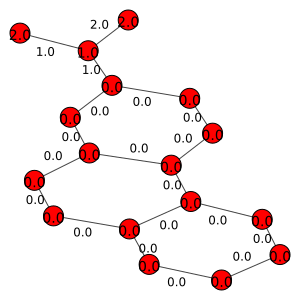

In [3]:
#Small molecule
graph = ig.Graph.Read_Picklez("Datasets/preprocessed/MUTAG/000.pickle")
layout = graph.layout("kk")
ig.plot(graph, layout = layout,bbox=(300,300))

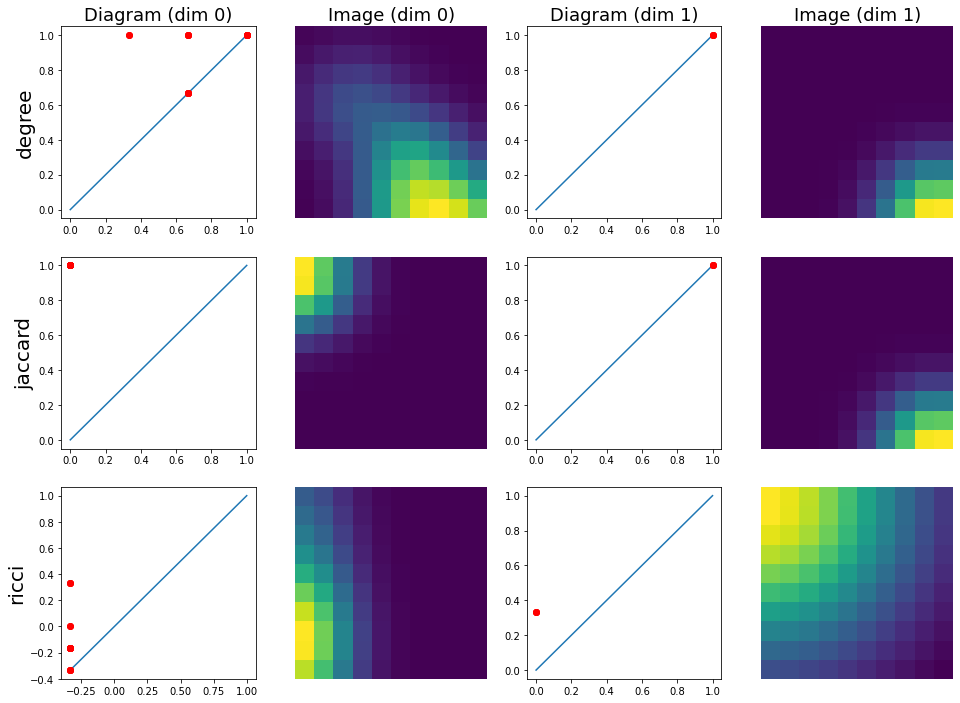

In [4]:
plot_persistence_diagrams_images(graph,filtrations=["degree","jaccard","ricci"])

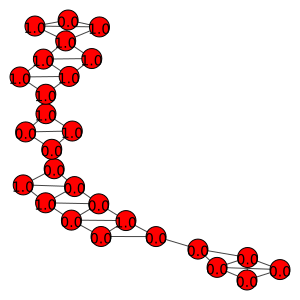

In [5]:
#Protein
graph = ig.Graph.Read_Picklez("Datasets/preprocessed/PROTEINS/0001.pickle")
layout = graph.layout("kk")
ig.plot(graph, layout = layout,bbox=(300,300))

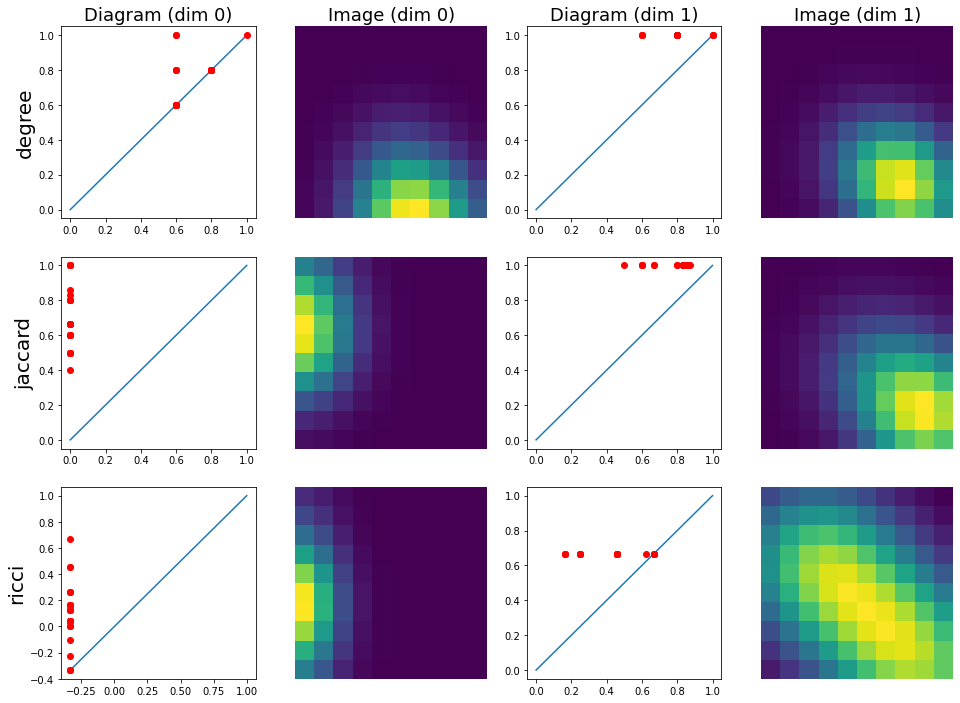

In [6]:
plot_persistence_diagrams_images(graph,filtrations=["degree","jaccard","ricci"])

# Comparison of classification performance with existing methods

In this section, I compare the accuracy that I get when I classify graph datasets with a random forest, using persistence images as features, to existing methods (WL and P-WL-UC) and to a baseline method which classifies only based the number of nodes in the graph. I took the results of WL and P-WL-UC from Zhao and Wang, NeurIPS 2019 (surprisingly, the results of WL are a bit different from those reported in the P-WL paper).

Here, I use a degree-based filtration and I only use connected components. As we will see below, using a different filtration (Jaccard index or Ricci curvature), and adding cycles does not have a significant impact on the accuracy, for most datasets.

Overall, the classification accuracy with persistence images is not too far from WL and P-WL-UC for most datasets, even though it does not take the labels into account. However, the performance is also not much better than a very simple classifier based only on the number of nodes.

In [7]:
np.random.seed(41)
scoring_metric = "accuracy"
param_grid = [{ "n_estimators": [ 100], "max_depth":[5, 10, 25]}]

In [8]:
%%time 
datasets = ["MUTAG","PROTEINS","DD","NCI1","IMDB-BINARY"]
results = {"Mine":{}}
for dataset in tqdm(datasets,desc="Datasets"):
    images,y = generate_img_dataset(dataset=dataset,filtration="degree",order="sublevel",
                                    spread = 0.2, pixels=[10,10],dimensions=[0])
    #Perform 10 times a 10-fold cross-validation, with an inner 5-fold CV for hyperparameter tuning
    mean_accuracies=[]
    for i in range(10):
        clf = GridSearchCV(RandomForestClassifier(),param_grid=param_grid,scoring = scoring_metric,n_jobs=-1,cv=5)
        scores = cross_val_score(clf,X=images,y=y,cv=10)
        mean_accuracies.append(np.mean(scores))
    results["Mine"][dataset] = "{:.1f}\u00B1{:.1f}".format(np.mean(mean_accuracies)*100,
                                                           np.std(mean_accuracies)*100)

Datasets: 100%|██████████| 5/5 [24:41<00:00, 296.29s/it]

CPU times: user 13min 2s, sys: 4.91 s, total: 13min 7s
Wall time: 24min 41s


In [9]:
results["WL"] = {"MUTAG": "84.4 \u00B1 1.5", "PROTEINS": "71.2 \u00B1 0.8", 
                "DD": "78.6 \u00B1 0.4","NCI1": "85.4 \u00B1 0.3", "IMDB-BINARY": "70.8 \u00B1 0.5"}
results["P-WL-UC"] = {"MUTAG": "85.2 \u00B1 0.3", "PROTEINS": "75.9 \u00B1 0.8", 
                "DD":"78.5 \u00B1 0.4","NCI1": "85.6 \u00B1 0.3", "IMDB-BINARY": "73.0 \u00B1 1.0"}

# Baseline method (only use the number of nodes in each graph)
results["count_nodes"]={}
for dataset in datasets:
    X,y=count_nodes(dataset)
    mean_accuracies=[]
    for i in range(10):
        clf = RandomForestClassifier(max_depth=1)
        scores = cross_val_score(clf,X=X,y=y,cv=10)
        mean_accuracies.append(np.mean(scores))
    results["count_nodes"][dataset] = "{:.1f}\u00B1{:.1f}".format(np.mean(mean_accuracies)*100,
                                                                  np.std(mean_accuracies)*100)
df = pd.DataFrame(results)
print(df)

                 Mine          WL     P-WL-UC count_nodes
MUTAG        82.8±0.6  84.4 ± 1.5  85.2 ± 0.3    81.8±0.7
PROTEINS     73.7±0.4  71.2 ± 0.8  75.9 ± 0.8    72.4±0.1
DD           74.8±0.3  78.6 ± 0.4  78.5 ± 0.4    75.7±0.2
NCI1         66.1±0.3  85.4 ± 0.3  85.6 ± 0.3    61.5±0.1
IMDB-BINARY  71.0±0.3  70.8 ± 0.5  73.0 ± 1.0    59.7±0.3


# 3 different filtrations

In this section, I compare the classification accuracy when using 3 different filtrations:
* **Degree** filtration: the weight of each node $u$ is its degree divided by the maximum degree in the graph: $\frac{\deg(u)}{\max_{v \in G} \deg(v)}$, and the weight of each edge $(u,v)$ is the maximum weight of its two nodes.
* **Jaccard index** filtration: the weight of each edge $(u,v)$ is one minus the Jaccard index between the neighbourhood sets of its two nodes: $1 - \frac{|N(u) \cap N(v)|}{|N(u) \cup N(v)|}$
* **Ollivier's Ricci curvature** filtration: a probability distribution is assigned to each node, depending on its 1-neighbourhood, and the weight of each edge is one minus the Wasserstein distance between the probability distributions of the two nodes. This filtration takes significantly longer to compute.

Most of the time, the different filtrations give similar results. However, for small molecules (MUTAG, NCI1), the Jaccard index is 0 for all edges, which results in all points in the persistence diagram to overlap, and the only information that is left in the persistence image is the number of nodes. This is sufficient to get a good classification accuracy for MUTAG, but not for NCI1.

The filtration might be included in the estimator as a hyperparameter, to be chosen during cross-validation (possibly excluding the ricci curvature for large graphs).


In [14]:
%%time 
datasets = ["MUTAG", "PROTEINS", "NCI1"]
filtrations = ["degree","jaccard","ricci"]
results = {"degree":{},"jaccard":{},"ricci":{}}
for dataset in tqdm(datasets,desc="Datasets"):
    for filtration in filtrations:
        images,y = generate_img_dataset(dataset=dataset,filtration=filtration,order="sublevel",
                                        spread = 0.2, pixels=[10,10],dimensions=[0])
        #Perform 10 times a 10-fold cross-validation, with an inner 5-fold CV for hyperparameter tuning
        mean_accuracies = []
        for i in range(10):
            clf = GridSearchCV(RandomForestClassifier(),param_grid=param_grid,scoring = scoring_metric,n_jobs=-1,cv=5)
            scores = cross_val_score(clf,X=images,y=y,cv=10)
            mean_accuracies.append(np.mean(scores))
        results[filtration][dataset] = "{:.1f}\u00B1{:.1f}".format(np.mean(mean_accuracies)*100,
                                                                  np.std(mean_accuracies)*100)

Datasets: 100%|██████████| 3/3 [55:13<00:00, 1104.63s/it]

CPU times: user 34min 56s, sys: 4min 27s, total: 39min 24s
Wall time: 55min 13s


In [15]:
df = pd.DataFrame(results)
print(df)

            degree   jaccard     ricci
MUTAG     83.1±0.7  83.1±0.3  83.3±0.4
PROTEINS  73.8±0.5  73.0±0.4  72.9±0.3
NCI1      66.3±0.3  61.4±0.3  67.1±0.3


# Connected components and/or cycles

In this section, I compare the classification accuracy when I use:
* only the connected components (dimension 0)
* only the cycles (dimension 1)
* connected components and cycles (dimensions 0 and 1). In this case, I produce one persistence image for each dimension, and I concatenate their vector representations.

The 3 methods have similar performance.

In [12]:
%%time 
datasets = ["MUTAG","PROTEINS", "IMDB-BINARY"]
dims = [ [0] , [1], [0,1] ]
results = {"[0]":{},"[1]":{},"[0, 1]":{}}
for dataset in tqdm(datasets,desc="Datasets"):
    for dim in dims:
        images,y = generate_img_dataset(dataset=dataset,filtration="degree",order="sublevel",
                                        spread = 0.2, pixels=[10,10],dimensions=dim)
        mean_accuracies = []
        for i in range(10):
            clf = GridSearchCV(RandomForestClassifier(),param_grid=param_grid,scoring = scoring_metric,n_jobs=-1,cv=5)
            scores = cross_val_score(clf,X=images,y=y,cv=10)
            mean_accuracies.append(np.mean(scores))
        results[str(dim)][dataset] = "{:.1f}\u00B1{:.1f}".format(np.mean(mean_accuracies)*100,
                                                                 np.std(mean_accuracies)*100)

Datasets: 100%|██████████| 3/3 [23:31<00:00, 470.52s/it]

CPU times: user 11min 32s, sys: 5.03 s, total: 11min 37s
Wall time: 23min 31s


In [13]:
df = pd.DataFrame(results)
print(df)

                  [0]       [1]    [0, 1]
MUTAG        83.0±0.9  83.9±0.0  83.4±0.6
PROTEINS     73.8±0.4  71.9±0.3  73.7±0.4
IMDB-BINARY  71.8±0.4  69.9±0.3  70.8±0.3
